# 0) Dependencise

In [39]:
import sys
from pathlib import Path

# data processing libraries
import pandas as pd
import numpy as np
import datetime
import re

# modeling 
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# here put thoses algorithms
from sklearn.linear_model import LinearRegression


# metrics 
from scipy.optimize import least_squares
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] #change size of plot
import plotly.express as px

# 1) Data Acquistion

A quick look at:
1. Data Structure / Data Info
2. Categorical Variables
3. Numerical Variables


In [ ]:
life_expectancy_data = pd.read_csv("Life Expectancy Data.csv")

## 1.1) A quick look at the data structure

In [21]:
df = life_expectancy_data.copy()

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
# Trim the spaces in the column names
trimed_col = []
for col in df.columns:
    trimed_name = col.strip()
    trimed_name = trimed_name.replace("  "," ")

    if trimed_name not in ['BMI', 'HIV/AIDS','GDP']:
        trimed_col.append(trimed_name.title())
    else:
        trimed_col.append(trimed_name)
    
df.columns = trimed_col

# Note that according to the data dictionary, the first column of thinness represent
# Rate of thinness among people aged 10-19. Hence we should rename the column from '1-19' to '10-19'.
df.rename(columns = {'Thinness 1-19 Years':'Thinness 10-19 Years'},inplace = True)
df.columns

In [ ]:
df.info()

## 1.2) A quick look at the distribution of the categorical variables

In [ ]:
df['Country'].value_counts()

In [ ]:
df['Status'].value_counts()

## 1.3) A quick look at the distribution of numerical variables

In [ ]:
df.describe()

In [40]:
IMAGES_PATH = Path() / "images" / "life_expectancy"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  
plt.show()

## 1.4) Sample a test set (remain unseen)

### 1.4.1) Method 1:  Randomly split the data using np.randodm.permutation

In [65]:
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [70]:
np.random.seed(123)

train_set, test_set = shuffle_and_split_data(df, 0.2)

print(len(train_set),len(test_set))

2351 587


In [ ]:
train_set.isnull().sum()

In [ ]:
test_set.isnull().sum()

### 1.4.2) Method 2: Using hash() function

In [49]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [60]:
df_with_id = df.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(df_with_id, 0.2, "index")

In [61]:
print(len(train_set),len(test_set))

2348 590


In [ ]:
train_set.isnull().sum()

In [ ]:
test_set.isnull().sum()

### 1.4.3) Method 3: Using sklearn model selection

In [75]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=123)

In [57]:
print(len(train_set),len(test_set))

2350 588


In [ ]:
train_set.isnull().sum()

In [ ]:
test_set.isnull().sum()

# 2) Data Exploration

In this step, we use panda profiling to explore the following:
- Descriptive Statistics
- Missing Data (%)
- Duplicates (%)
- Correlation


In [74]:
le = train_set.copy()

## 2.1) Pandas Profiling

Pandas Profiling generates a global deatiled report about the dataset, including the number of records, the number of features, overall missingness and duplicates. It also includes descriptive statistics for each individual variables and correlation statistics between the variables. Refer to 'output.html' to see the report.

In [85]:
import pandas_profiling

#le.profile_report(style = {'full_width':True})
#profile = le.profile_report()
#rejected_varaibles = profile.get_rejected_variables(threshold=0.9)

profile = le.profile_report(title='Pandas Profiling Report')
#profile.to_widgets()
profile.to_file("output.html")

Summarize dataset:  79%|███████▉  | 23/29 [00:00<00:00, 79.90it/s, Calculate auto correlation]                       C:\Users\shans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\multimethod\__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


### 2.2) Correlation HeatMap

In [87]:
corr_matrix = le.corr()

C:\Users\shans\AppData\Local\Temp\ipykernel_15984\959763787.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = le.corr()


In [ ]:
corr_matrix['Life Expectancy'].sort_values(ascending = False)

Life Expectancy                    1.000000
Schooling                          0.748420
Income Composition Of Resources    0.714599
BMI                                0.567541
Diphtheria                         0.484124
Polio                              0.478217
GDP                                0.463291
Alcohol                            0.396350
Percentage Expenditure             0.381295
Hepatitis B                        0.254609
Total Expenditure                  0.213044
Year                               0.169870
Population                        -0.025508
Measles                           -0.158701
Infant Deaths                     -0.199090
Under-Five Deaths                 -0.226288
Thinness 5-9 Years                -0.468309
Thinness 10-19 Years              -0.475991
HIV/AIDS                          -0.555878
Adult Mortality                   -0.696440
Name: Life Expectancy, dtype: float64

C:\Users\shans\AppData\Local\Temp\ipykernel_15984\4033860681.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(le.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


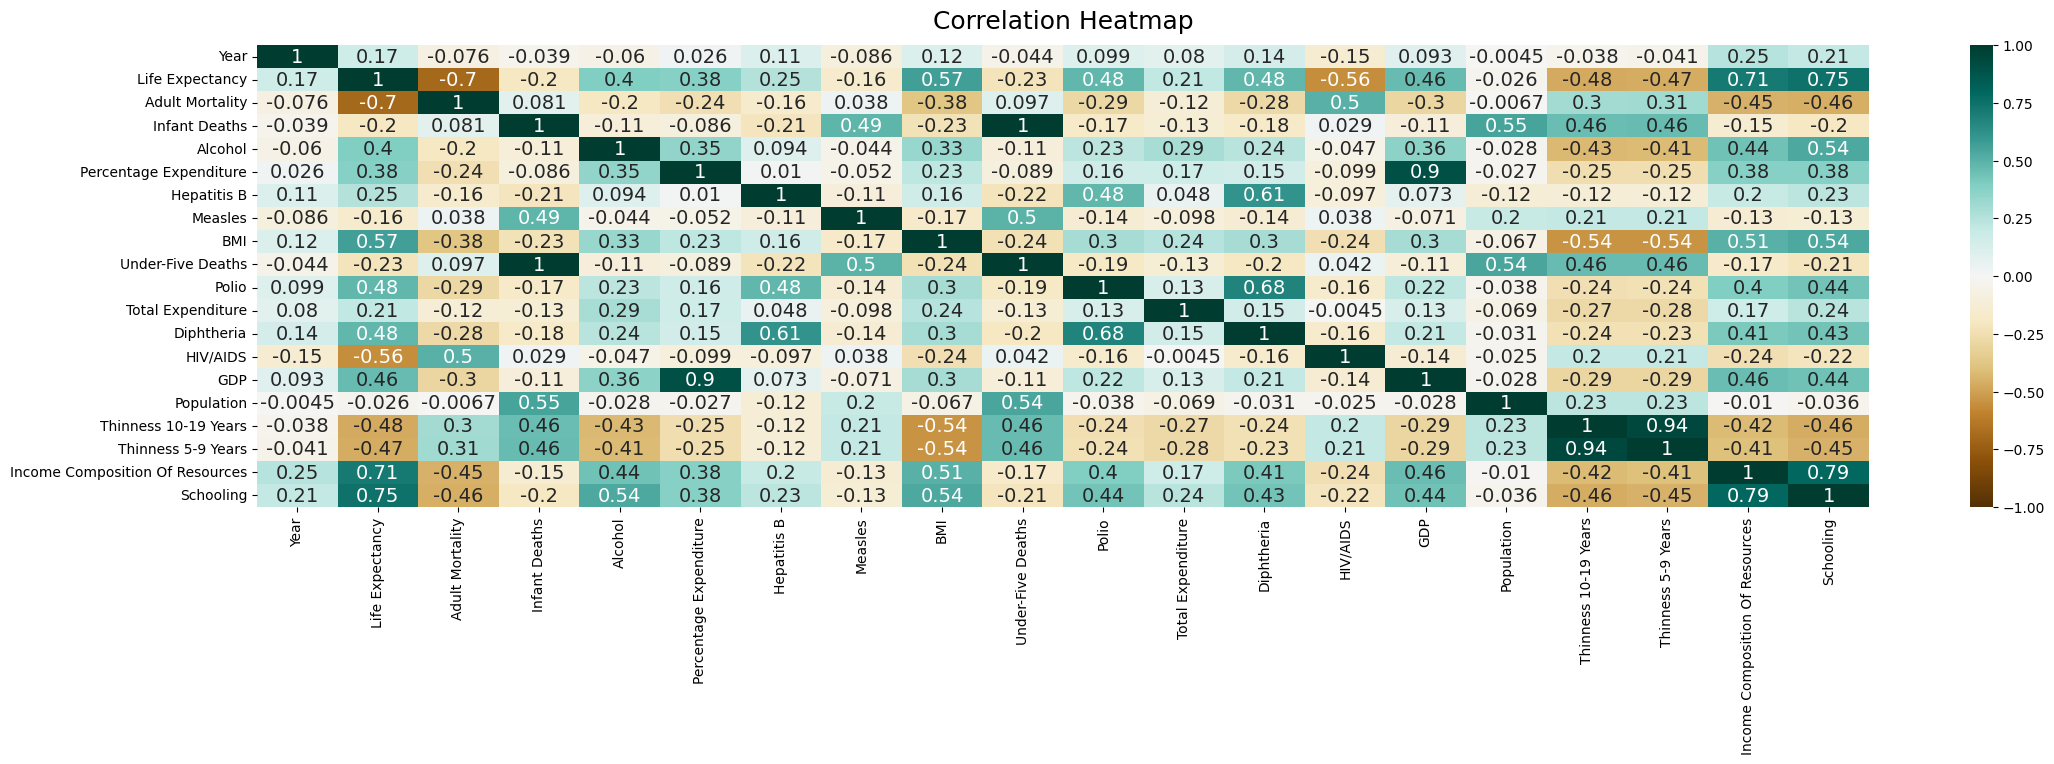

In [86]:
# check if there is any collinearity between variables
plt.figure(figsize=(26, 6))
heatmap = sns.heatmap(le.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

To further explore the relationship between LifeExpectancy and each independent variable, certain data cleaning needs to be done.

# 3) Data Cleaning

1. Dealing with Missing data
2. Handling Multi-Conllinearity
(Cleaning data)
3. Outlier Detection
4. Data Preprocessing
5. Feature Selection
6. Feature engineering
7. Feature Scaling
8. Clustering
9. Imbalanced data

### 2.2.1) With Categorical Variables

In [ ]:
# Life Expectancy w.r.t. Status
plt.figure(figsize=(5,5))
plt.bar(le.groupby('Status')['Status'].count().index, le.groupby('Status')['Life Expectancy'].mean() )
plt.xlabel("Status")
plt.ylabel("Avg Life_Expectancy")
plt.title("Life Expectancy w.r.t. Status")
plt.show()

In [ ]:
# Life Expectancy w.r.t. Country
le.groupby('Country')['Life Expectancy'].mean().plot(kind="bar", fontsize=3)
plt.xlabel("Country")
plt.ylabel("Avg Life_Expectancy")
plt.title("Life Expectancy w.r.t. Country")
plt.show()

In [ ]:
# Life Expectancy over Years
avg_life_exp = le.groupby(le['Year'])['Life Expectancy'].mean()
plt.plot(avg_life_exp)

# 4) Modelling

1. Training
2. Cross-Validation
3. Fine tuning
4. Evaluate on test set